# Prediction with Machine Learning HW2
## Mukhamejan Assan

Business: Your task will be to help a company operating small and mid-size apartments hosting 2-6 guests. The company is set to price their new apartments not on the market. 

Build a price prediction model similarly to how we did in our case study for London. 

Discuss your modeling decisions and compare your results to those of the case study. 


## Part I. Accessing and Cleaning Data

In [147]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [148]:
df = pd.read_csv('listings.csv')
df.shape 

(11056, 75)

### The variables, their description, and type

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11056 entries, 0 to 11055
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            11056 non-null  int64  
 1   listing_url                                   11056 non-null  object 
 2   scrape_id                                     11056 non-null  int64  
 3   last_scraped                                  11056 non-null  object 
 4   source                                        11056 non-null  object 
 5   name                                          11054 non-null  object 
 6   description                                   11018 non-null  object 
 7   neighborhood_overview                         7087 non-null   object 
 8   picture_url                                   11056 non-null  object 
 9   host_id                                       11056 non-null 

In [150]:
df.keys()

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

Some of the 73 variables may not be useful. 

1. Variables that cannot be changed:

    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name'

2. Variables that are not relevant because the listings have not yet been introduced into the market:

    'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url','host_neighbourhood', 'host_listings_count', 'host_total_listings_count','host_verifications','host_has_profile_pic', 'host_identity_verified', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 'review_scores_location','review_scores_value'

In [151]:
df.shape

(11056, 75)

In [152]:
df.drop(
    ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name','host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url','host_neighbourhood', 'host_listings_count', 'host_total_listings_count','host_verifications','host_has_profile_pic', 'host_identity_verified', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 'review_scores_location','review_scores_value'],
    inplace=True,
    axis=1
)

### EDA and sample definition and preparation

#### Cleaning, cutting, zooming in

We are only interested in apartments.
1. Check if property types are all indicated 
2. keep only apartments

In [153]:
print(df["property_type"].isnull().sum(), "property types are missing.")

0 property types are missing.


Property types do not seem to be well-defined. I will find the apartment listings by finding the `partment` in descriptions and then select the property types that say either "Entire" or "Home" but not "room".

In [154]:
print(df[df['description'].str.contains('partment',na=False)].property_type.value_counts())
df = df[df['description'].str.contains('partment',na=False)]

Entire rental unit                    4843
Entire condo                          1419
Private room in rental unit            192
Entire serviced apartment              175
Entire loft                             93
Entire home                             89
Room in aparthotel                      83
Private room in condo                   63
Room in serviced apartment              38
Private room in serviced apartment      26
Room in boutique hotel                  12
Entire vacation home                    11
Private room in guest suite             11
Shared room in rental unit              10
Entire guest suite                       9
Room in hotel                            8
Entire townhouse                         5
Tiny home                                4
Private room in bed and breakfast        3
Private room in vacation home            2
Entire villa                             2
Entire place                             2
Private room in hostel                   2
Private roo

In [155]:
# keeping only the apartments
df = df[df.property_type.apply(lambda x: ("Entire" in x or 'ome' in x) and 'room' not in x).to_list()]
# What is left in the end? 
df.property_type.value_counts()
# Still way too many categories. Focus on the 4 biggest, and give a sensible name to each. 
df = df[df['property_type'].apply(lambda x: x in ("Entire rental unit Entire condo Entire serviced apartment Entire loft"))]

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text
d = { "Entire rental unit": "Apartment", "Entire condo": "Condo", "Entire serviced apartment": "Serviced apartment","Entire loft" : "Loft"}

df['property_type'] = replace_all(df["property_type"], d)


In [156]:
df['property_type'].value_counts()

Apartment             4843
Condo                 1419
Serviced apartment     175
Loft                    93
Name: property_type, dtype: int64

Now, we need to limit our data to apartments which accomodate 2-6 people. 

In [157]:
df = df[df['accommodates'].between(2,6)]

#### Missing values

There are 17229 missing values in total


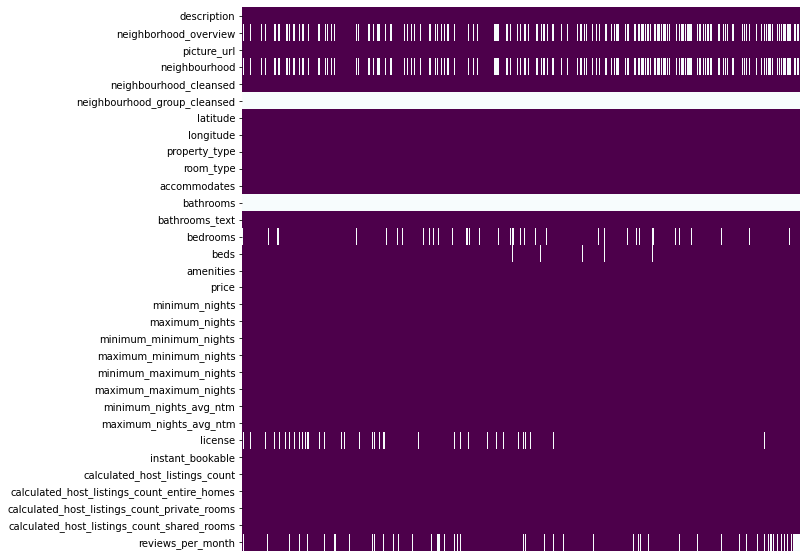

In [158]:
# Check for missing values frequency
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df.isnull().T, xticklabels=False, cbar=False, cmap='BuPu_r', ax=ax)
print('There are', df.isna().sum().sum(), 'missing values in total')

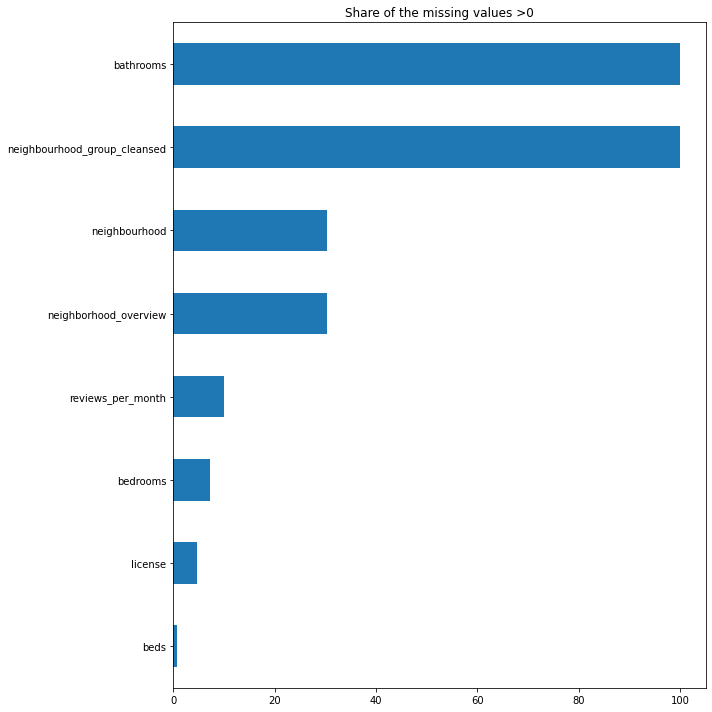

In [159]:
# focus on features with missing values
na_share = df.isnull().mean()*100
fig, ax = plt.subplots(figsize=(10,10))    
na_share[na_share>0].sort_values(ascending=True).plot.barh(title = 'Share of the missing values >0')
plt.tight_layout()

In [160]:
na_share[na_share>0].sort_values(ascending=False)

neighbourhood_group_cleansed    100.000000
bathrooms                       100.000000
neighborhood_overview            30.378289
neighbourhood                    30.378289
reviews_per_month                10.065789
bedrooms                          7.138158
license                           4.753289
beds                              0.657895
dtype: float64

#### omg